In [69]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV
from scipy.stats import uniform

import shap
import joblib

In [29]:
df = pd.read_csv("final.csv")
df.head()

,TotalRevenue,AvgRevenuePerClaim,RevenueStd,RevenuePerBeneficiary,DeductibleRatio,TotalClaims,UniquePatients,ClaimsPerPatient,InpatientRatio,HighCostRatio,...,AvgLengthOfStay,AvgChronicBurden,ShortNoteRatio,HighCostShortNoteRatio,AvgWordCount,MedicalTermDensity,ClaimAfterDeathCount,AgeStd,RevenueMedianGap,PotentialFraud
0,104640,4185.600000,10796.091144,4185.600000,0.051032,25,24,1.000000,0.200000,0.200000,...,1.440000,1.464000,0.000000,0.000000,537.280000,2.280000,0,11.915256,3785.600000,0
1,605670,4588.409091,7309.794729,5132.796610,0.109442,132,117,1.118644,0.469697,0.469697,...,3.674242,1.553030,0.022727,0.022727,458.977273,2.515152,0,13.461823,2838.409091,1
2,52170,350.134228,689.963754,375.323741,0.005942,149,138,1.071942,0.000000,0.060403,...,1.429530,1.576510,0.006711,0.000000,511.402685,2.751678,0,12.918061,280.134228,0
3,280910,241.124464,491.556392,566.350806,0.013171,1165,495,2.348790,0.000000,0.023176,...,1.088412,1.580601,0.015451,0.000000,486.928755,2.706438,0,13.357434,171.124464,1
4,33710,468.194444,1433.769116,571.355932,0.096823,72,58,1.220339,0.041667,0.055556,...,0.958333,1.600000,0.055556,0.013889,428.208333,2.513889,0,14.628679,388.194444,0


In [ ]:
def rule_engine(row):

    if row["ClaimAfterDeathCount"] > 0:
        return "CRITICAL: Billing After Death"

    if row["InpatientRatio"] > 0.98 and row["AvgLengthOfStay"] < 1:
        return "CRITICAL: Impossible Stay Pattern"

    if row["RevenuePerBeneficiary"] > 100000 and row["AvgChronicBurden"] < 0.2:
        return "CRITICAL: Extreme Billing With Low Severity"

    if row["HighCostRatio"] > 0.95:
        return "CRITICAL: Nearly All Claims High Cost"


    if row["ClaimsPerPatient"] > 12:
        return "HIGH: Extreme Repeat Billing"

    if row["RevenueStd"] == 0 and row["TotalClaims"] > 20:
        return "HIGH: Identical Billing Pattern"

    if row["RevenueMedianGap"] > 25000:
        return "HIGH: Severe Cost Skew"

    if row["InpatientRatio"] > 0.85 and row["AvgDiagnosisCount"] < 2:
        return "HIGH: Too Many Admissions Low Diagnosis"

    if row["DeductibleRatio"] < 0.01 and row["TotalRevenue"] > 500000:
        return "HIGH: Suspicious Deductible Pattern"

    if row["UniquePatients"] < 10 and row["TotalClaims"] > 200:
        return "HIGH: Few Patients Too Many Claims"
 

    if row["ShortNoteRatio"] > 0.75:
        return "MEDIUM: Weak Documentation"

    if row["MedicalTermDensity"] < 1.5:
        return "MEDIUM: Low Clinical Language"

    if row["AvgWordCount"] < 10 and row["AvgRevenuePerClaim"] > 20000:
        return "MEDIUM: Expensive Claims Poor Notes"

    if row["AgeStd"] < 2 and row["TotalClaims"] > 100:
        return "MEDIUM: Unnatural Patient Demographics"

    if row["AvgProcedureCount"] > 6 and row["AvgDiagnosisCount"] < 2:
        return "MEDIUM: Too Many Procedures Few Diagnoses"

    if row["RevenuePerBeneficiary"] > 50000 and row["ClaimsPerPatient"] > 6:
        return "MEDIUM: High Spending + High Frequency"

    if row["AvgLengthOfStay"] > 15:
        return "MEDIUM: Long Stay Pattern"

    if row["HighCostRatio"] > 0.6 and row["AvgChronicBurden"] < 0.3:
        return "MEDIUM: High Cost Low Complexity"
    
    return "PASS"

In [31]:

df["RuleFlag"] = df.apply(rule_engine, axis=1)

rule_fail = df[df["RuleFlag"] != "PASS"]
rule_pass = df[df["RuleFlag"] == "PASS"]

In [32]:
X = rule_pass.drop(columns=["PotentialFraud","RuleFlag"])
y = rule_pass["PotentialFraud"]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [55]:
pipeline = Pipeline([
    ("imputer",SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=2000, l1_ratio=1, solver='liblinear', C=.3538))
])

In [56]:
pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('imputer', ...), ('scaler', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'mean'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imputation. If 

In [58]:
pred = pipeline.predict(X_test)
prob = pipeline.predict_proba(X_test)[:,1]

In [59]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    pipeline,
    X,
    y,
    cv=cv,
    scoring="roc_auc"
)

print("CV ROC-AUC Scores:", scores)
print("Mean Score:", scores.mean())

CV ROC-AUC Scores: [0.93860422 0.92994435 0.95066314 0.93188209 0.93147202]
Mean Score: 0.9365131640611513


In [60]:
# param_dist = {
#     "model__C": uniform(0.01, 10),
#     "model__penalty": ["l1", "l2"],
#     "model__solver": ["liblinear"],
#     "model__max_iter": [1600, 2000, 2200]
# }

# search = RandomizedSearchCV(
#     pipeline,
#     param_dist,
#     n_iter=30,
#     scoring="roc_auc",
#     cv=5,
#     random_state=42,
#     n_jobs=-1
# )

# search.fit(X_train, y_train)

# best_model = search.best_estimator_

# print("Best Params:", search.best_params_)
# print("Best Score:", search.best_score_)

In [61]:
print(classification_report(y_test, pred))
print("ROC AUC:", roc_auc_score(y_test, prob))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       900
           1       0.85      0.55      0.67       103

    accuracy                           0.94      1003
   macro avg       0.90      0.77      0.82      1003
weighted avg       0.94      0.94      0.94      1003

ROC AUC: 0.9424811218985977


In [62]:
importance = pd.Series(
    pipeline.named_steps["model"].coef_[0],
    index=X.columns
)

importance.sort_values(ascending=False)

RevenuePerBeneficiary     1.185593
TotalRevenue              0.912635
RevenueStd                0.607209
TotalClaims               0.519093
HighCostRatio             0.410077
ClaimsPerPatient          0.360399
RevenueMedianGap          0.347217
AvgProcedureCount         0.271818
AvgLengthOfStay           0.161999
AgeStd                    0.145962
AvgWordCount              0.037818
UniquePatients            0.029308
InpatientRatio            0.000000
MedicalTermDensity        0.000000
ClaimAfterDeathCount      0.000000
AvgDiagnosisCount         0.000000
ShortNoteRatio           -0.027854
DeductibleRatio          -0.036580
AvgChronicBurden         -0.048732
HighCostShortNoteRatio   -0.082136
AvgRevenuePerClaim       -1.940799
dtype: float64

In [63]:
explainer = shap.Explainer(
    pipeline.named_steps["model"],
    X_train
)

shap_values = explainer(X_test)

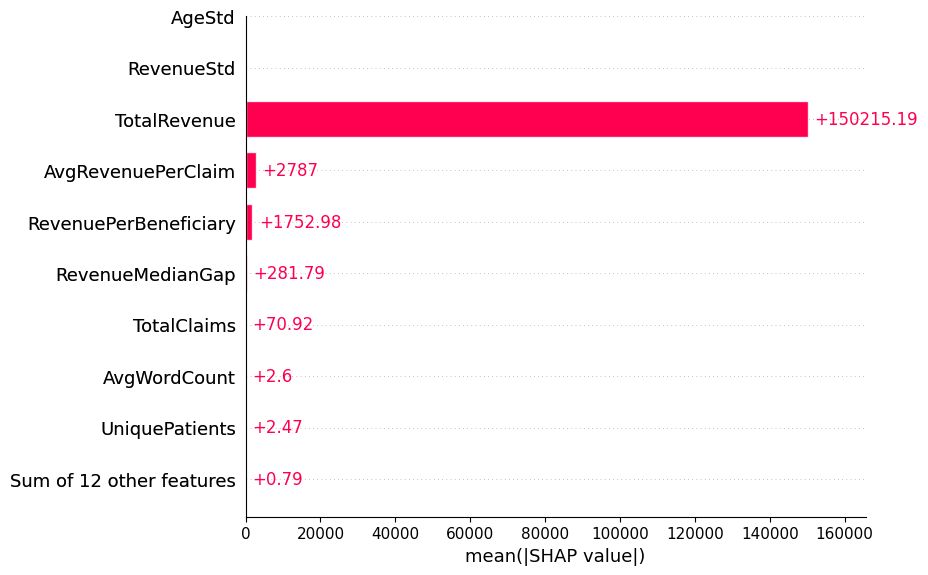

In [64]:
shap.plots.bar(shap_values)

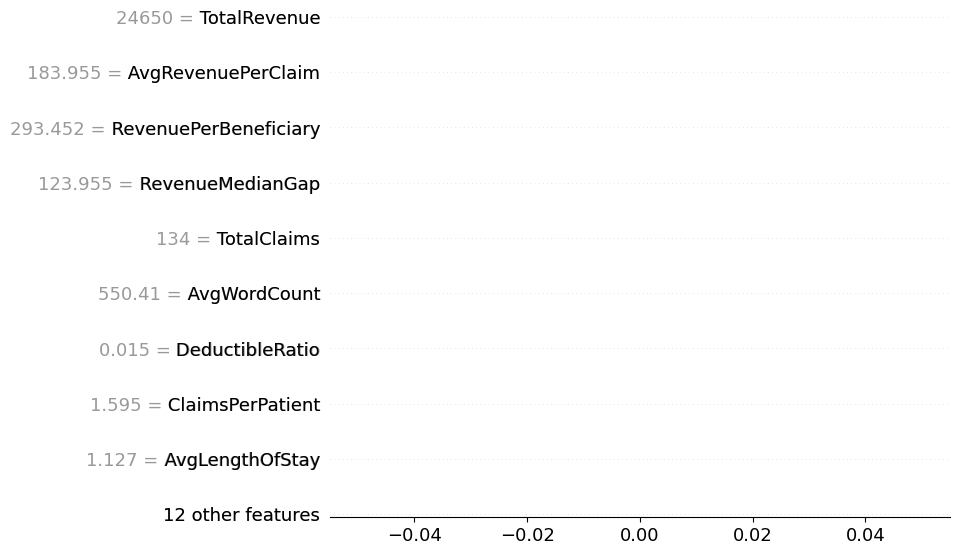

In [65]:
shap.plots.waterfall(shap_values[0])

In [66]:
df["RiskScore"] = pipeline.predict_proba(
    df[X.columns]
)[:,1]

In [67]:
def final_decision(row):

    if row["RuleFlag"] != "PASS":
        return row["RuleFlag"]

    if row["RiskScore"] > 0.80:
        return "ML HIGH RISK"

    if row["RiskScore"] > 0.60:
        return "ML MEDIUM RISK"

    return "LOW RISK"

df["FinalDecision"] = df.apply(final_decision, axis=1)

In [68]:
df.to_csv("fraud_predictions.csv", index=False)

In [71]:
joblib.dump(pipeline, 'trustguard.pkl')

['trustguard.pkl']